In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
data_path = [
    'data/food32/Food32/train', 
    'data/food32/UPMC32/train'
]

stat_dict = defaultdict(list)
for data in data_path:
    img_path_list = glob.glob(
        os.path.join(data, '*', '*.jpg')
    )
    data_name = data.split('/')[2]
    stat_dict[data_name] = img_path_list
    print(
        f"dataset: {data_name} | " 
        f"total_img_length: {len(img_path_list)}"
    )

dataset: Food32 | total_img_length: 32000
dataset: UPMC32 | total_img_length: 28412


In [10]:
from tqdm import tqdm

result = []
for data_name, img_path_list in stat_dict.items():
    print(f"dataset: {data_name}")
    hw_dict = defaultdict(list)
    for img_path in tqdm(img_path_list):
        img = cv2.imread(img_path)
        h, w, c = img.shape
        hw_dict['height'].append(h)
        hw_dict['width' ].append(w)
    result.append(hw_dict)

  0%|          | 33/32000 [00:00<01:37, 327.43it/s]

dataset: Food32


  0%|          | 50/28412 [00:00<00:58, 485.61it/s]

dataset: UPMC32


100%|██████████| 28412/28412 [01:20<00:00, 354.74it/s]


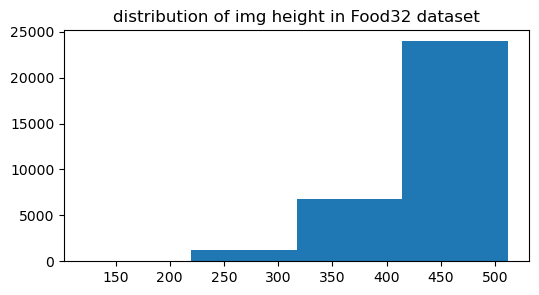

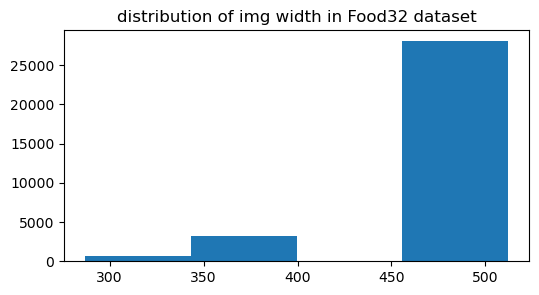

In [19]:
plt.figure(figsize=(6,3))
plt.title("distribution of img height in Food32 dataset")
plt.hist(result[0]['height'], bins=4)
plt.show()

plt.figure(figsize=(6,3))
plt.title("distribution of img width in Food32 dataset")
plt.hist(result[0]['width' ], bins=4)
plt.show()

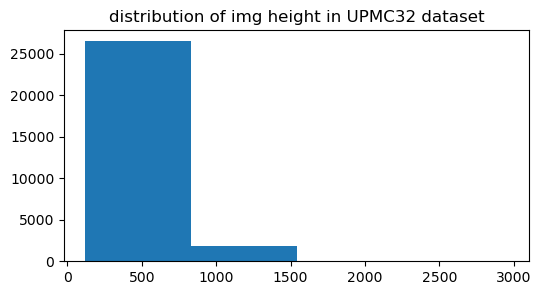

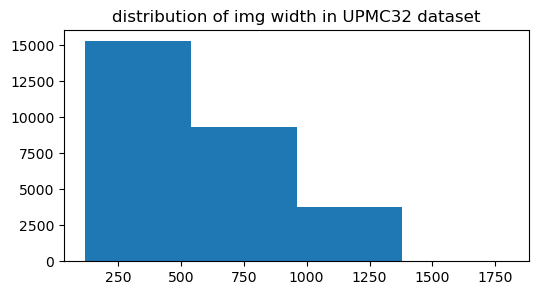

In [21]:
plt.figure(figsize=(6,3))
plt.title("distribution of img height in UPMC32 dataset")
plt.hist(result[1]['height'], bins=4)
plt.show()

plt.figure(figsize=(6,3))
plt.title("distribution of img width in UPMC32 dataset")
plt.hist(result[1]['width' ], bins=4)
plt.show()

Random images in Food32 dataset


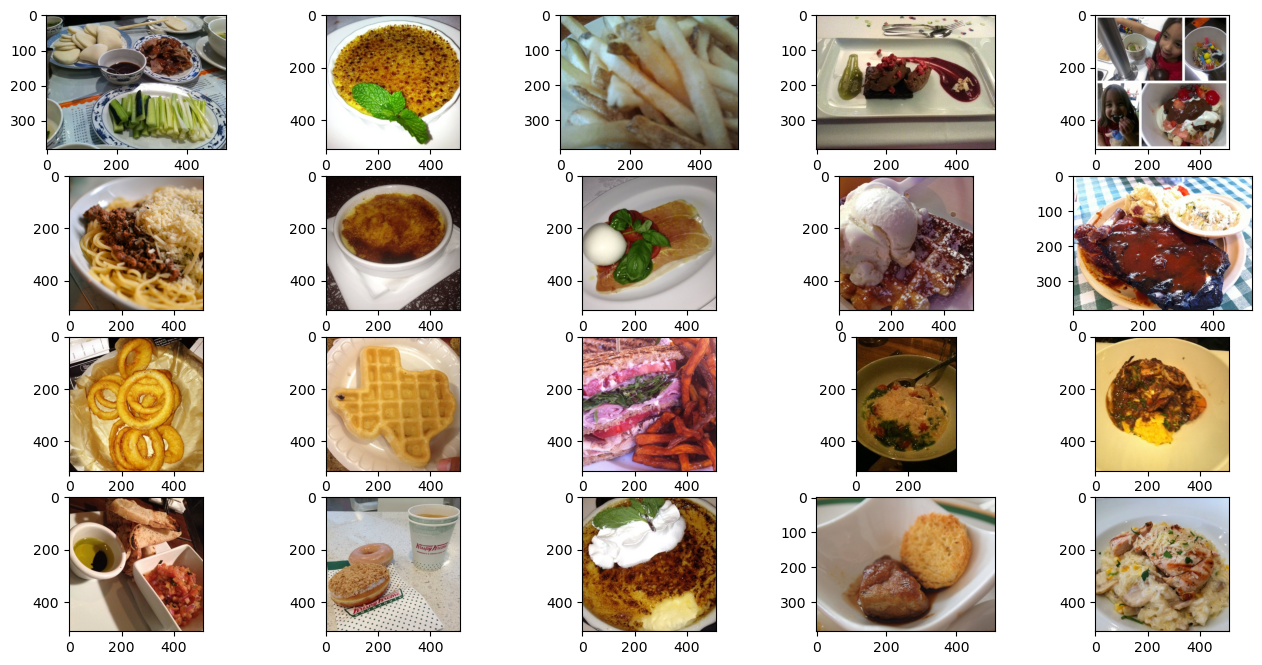

In [4]:
import random

print("Random images in Food32 dataset")
img_list = stat_dict['Food32']
f, axs = plt.subplots(4,5, figsize=(16,8))
for i in range(4):
    for j in range(5):
        axs[i][j].imshow(
            cv2.cvtColor(
                cv2.imread(
                img_list[random.randint(0,len(img_list)-1)]), 
                cv2.COLOR_BGR2RGB
            ) 
        )
    

Random images in UPMC32 dataset


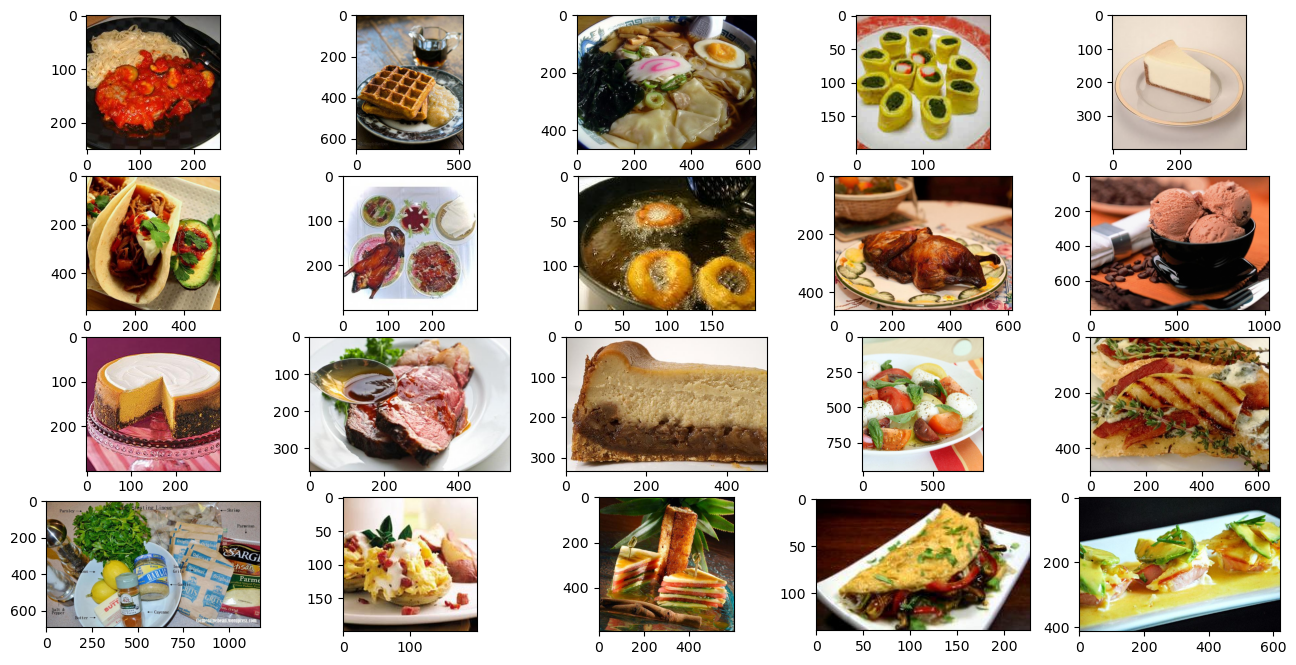

In [5]:
import random

print("Random images in UPMC32 dataset")
img_list = stat_dict['UPMC32']
f, axs = plt.subplots(4,5, figsize=(16,8))
for i in range(4):
    for j in range(5):
        axs[i][j].imshow(
            cv2.cvtColor(
                cv2.imread(
                img_list[random.randint(0,len(img_list)-1)]), 
                cv2.COLOR_BGR2RGB
            ) 
        )
    

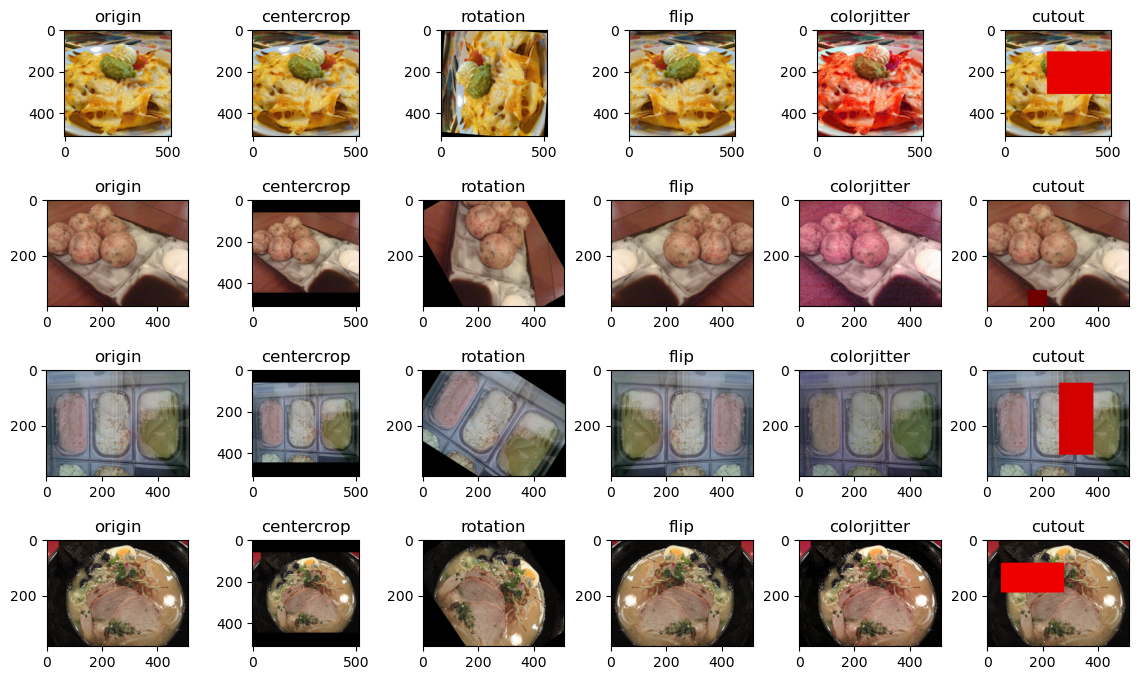

In [79]:
# !pip3 install torchtoolbox
from torchtoolbox.transform import Cutout

import torchvision
from PIL import Image
from copy import deepcopy

augs = {
    'resize': torchvision.transforms.Resize((512, 512)),
    'centercrop': torchvision.transforms.CenterCrop((512,512)),
    'rotation': torchvision.transforms.RandomRotation(90),
    'flip': torchvision.transforms.RandomHorizontalFlip(p=1),
    'colorjitter': torchvision.transforms.ColorJitter(0.2,0.1,0.1,0.1),
    'cutout': Cutout(p=1),
}

f, axs = plt.subplots(4, len(augs), figsize=(14,8))
plt.subplots_adjust(wspace=0.3, hspace=0.6)
for i in range(4):
    img_path = (
            stat_dict['Food32']
            [random.randint(0,len(img_list)-10)]
    )
    img = Image.open(img_path)
    ori = deepcopy(img)
    axs[i][0].imshow(ori)
    axs[i][0].set_title(f"origin")

    for j in range(1, len(augs)):
        aug_name = list(augs.keys())[j]
        aug_method = augs[aug_name]
        aug_img = aug_method(img)
        axs[i][j].imshow(aug_img)
        axs[i][j].set_title(f"{aug_name}")

ValueError: x and y can be no greater than 2-D, but have shapes (816,) and (816, 991, 3)

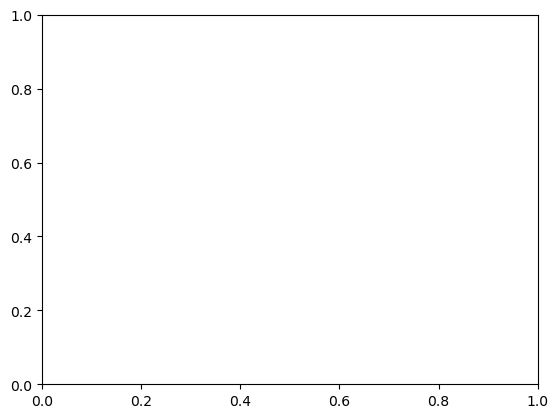

In [21]:
import cv2
import random
from copy import deepcopy
import ttach as tta
from PIL import Image
import torchvision.transforms as T
unloader = T.ToPILImage()


trans = T.Compose([
        T.Resize(1024),
        T.CenterCrop(512),
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ] 
)

# Add TTA
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 90]),
        tta.Scale(scales=[1, 2]),
        # tta.Multiply(factors=[0.9, 1.1]),
    ]
)

img_path = (
    stat_dict['UPMC32']
    [random.randint(0,len(img_list)-10)]
)
images = Image.open(img_path)
ori_images = deepcopy(images)

plt.plot(images)
for i, transformer in enumerate(transforms):  # custom transforms or e.g. tta.aliases.d4_transform()
    images = trans(ori_images).unsqueeze(0)
    # augment image
    augmented_image = transformer.augment_image(images)
    inv_image = augmented_image.cpu().clone()  # clone the tensor
    inv_image = inv_image.squeeze(0)  # remove the fake batch dimension
    inv_image = unloader(inv_image)
    plt.plot(inv_image)

